# Predicting Premier League Matches
> Using Neural Networks and gradient boosting to predict Football matches

- toc: true 
- badges: true
- comments: true
- categories: [neural networks,XGBoost, Football, Premier League,Python]

![](ghtop_images/header2.png)

## Overview

### Introduction

Predicting results of [English Premier League](https://en.wikipedia.org/wiki/Premier_League) using random forests for the 2017 to 2021 seasons. I will predict whether a result is a win, loss or draw, and then simplify as a binary question- is it a win?

From an article about pundit versus gambling company [Pinnacle vs. Mark Lawrenson](https://www.pinnacle.com/en/betting-articles/Soccer/Mark-Lawrenson-vs-Pinnacle-Sports/VGJ296E4BSYNURUB) we have a benchmark to aim for from the 2012 season:
- Mark Lawrenson = 52.6% accuracy
- Pinnacle traders = 55.3% accuracy
- Random guess = 33.3% accuracy

### Method

In this data there are various parameters that can be used. The most important step is to not use data about a current match as a predictor, but for a prediction to be based on stats from previous matches. (A couple of slight exceptions to this are below like who is playing who and where)

The predictors used here include:
- date of match
- home or away
- stats from previous matches
    - results
    - goals scored/conceded
    - possession/expected goals etc
- who is playing who


Some details on the machine learning:


- Notebook on [kaggle is here](https://www.kaggle.com/code/thomassimm/predicting-premier-league-matches)
- Several models were used:
    - A Random Forest [model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
    - Gradient boosting models [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html)
    - Ridge [model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier)
    - Neural networks
- Regression and classification models were used
- Data is trained on years 2017 to 2020 with season 2021 used as validation
    - 20% validation / 80% training
- Some data cleaning methods were performed and shown in the code

### Results

- Model accuracy = 52% (+-1%)
    - So the model is comparable with the results of Mark Lawrenson
- The model is okay as it matches the accuracy from an expert pundit. But it does underperform gambing predictions. 

- Draws are under-represented by the model
    - draws predicted was increased by adjusting the input parameter `class_weight` but the issue was only reduced 
- Changing input parameters was done in a semi-manual manner, obtaining the best input parameters was not easy

- The more parameters the better, 
    - but the increase from just using a basic four parameter fit to one with 300+ columns is relatively small (a difference of ~1-2% (based on values 50-65%))

- By searching for the best hyper parameters the results of a random forest (RF) model were increased from 49% accuracy to 52%

- RF, XG boost and grad boost methods all performed similar
    - Ridge model was the worst performing
    - Neural networks with fastai tabular data also performed poorly. [NN analysis of EPL](https://www.kaggle.com/code/thomassimm/epl-nn)
    
- Similar results were obtained by using classification and regression methods
    - Regression on the net score performed the best
    - Regression methods performed worse on predicting draws though
    
- Ensembling (combining results from different methods by adding them) can increase the overall results. The accuracy would need to be comparable and the results different enough for their to be a benefit

A summary of the results is shown below


|Accuracy W/L/D|Accuracy Win |Classification/Regression| Details|
|--------------|------------|---------|----|
|0.489		|0.669|		Classification|RF with all parameters|
|0.479		|0.661|		Classification|RF with 43 parameters from feature imp|
|0.487		|0.666|		Classification| RF as above with basic features|
|0.484		|0.656|		Classification| RF with 4 basic features|
|0.479		|-	|      	Classification| RF with 4 basic ones + balanced|
|0.485		|0.656|		Classification| RF with 23 correlation parameters plus basic|
|0.451		|0.678|		Regression| RF with all parameters on net score |
|-			|0.657|		Regression| XGB with all parameters on net score |
|-          |0.639|     Regression| Ridge with all parameters on net score |
|-          |0.666|     Regression| Grad boost with all parameters on net score |
|0.427      |0.670|     Regression| RF with all parameters on GF/GA |
|-          |0.670|     Regression| XGB with all parameters on GF/GA score |
|-          |0.665|     Regression| RF+XGB+Grad boost on netscore |
|-          |0.678|     Regression| RF on netscore + RF on GF/GA |



# This notebook

In this notebook I'll look at gradient boosting and neural networks. And then combine the results using Ensembling. i.e. the results of two different models predictions should be better than each individual one.



The binary version and more details on the models is found [here](https://www.kaggle.com/code/thomassimm/premier-league-predictions-using-tensorflow)


### Code- Prepare the data

Data is prepared in a separate page- [Predicting Premier League Matches- Prepare the data](https://thomashsimm.com/pandas/football/premier%20league/python/2022/08/11/PredictingPremierLeagueMatches-PrepareTheData.html#Save-the-data)


## Load data and libraries

In [1]:
#collapse-hide
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# from sklearn.tree import DecisionTreeClassifier
# from dtreeviz.trees import *
# from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
# from fastai.tabular.all import *

# from sklearn.experimental import enable_halving_search_cv  # noqa
# from sklearn.model_selection import HalvingRandomSearchCV


# from sklearn.metrics import precision_score
from xgboost import XGBClassifier

cwd=os.getcwd()
folda=cwd+"/data/epl/"
dira = os.listdir(folda)


In [2]:
#collapse-output

dfAll=pd.read_csv(folda+'epl2017-2021_wivnetscoreAndGFGA_both-HA_modPC.csv',index_col=0)
dfAll=dfAll.iloc[20:,:]
dfAll

,round,day,venue_x,result_x,gf_x,ga_x,opponent_x,shooting_gls_x,shooting_sh__x,shooting_sot_x,...,misc_int__y,misc_tklw__y,misc_pkwon_y,misc_pkcon_y,misc_og_y,misc_recov_y,misc_won_y,misc_lost_y,misc_won%_y,team_y
44,3,27,Home,0.000000,2.000000,2.000000,Everton,2.000000,14.500000,4.000000,...,13.000000,12.000000,0.000000,0.000000,0.000000,94.500000,19.500000,27.000000,41.150000,Everton
45,3,27,Away,0.000000,2.000000,2.000000,Liverpool,2.000000,23.000000,8.500000,...,16.000000,12.000000,0.500000,0.000000,0.000000,114.000000,28.500000,20.500000,57.450000,Liverpool
46,3,27,Away,0.000000,1.500000,1.500000,Tottenham Hotspur,1.500000,15.000000,3.000000,...,8.500000,9.000000,0.000000,0.000000,0.000000,91.000000,21.000000,22.500000,48.600000,Tottenham Hotspur
47,3,27,Away,0.500000,1.000000,0.500000,Chelsea,1.000000,8.000000,3.000000,...,7.000000,14.000000,0.000000,0.000000,0.500000,92.000000,23.500000,26.000000,47.850000,Chelsea
48,3,26,Away,0.500000,2.500000,2.000000,Manchester United,2.500000,10.000000,3.500000,...,16.000000,10.500000,0.000000,0.000000,0.000000,91.000000,21.500000,19.500000,50.300000,Manchester United
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,38,22,Away,0.333333,1.666667,1.333333,Arsenal,1.666667,9.333333,4.000000,...,10.000000,9.666667,0.000000,0.000000,0.333333,74.333333,14.666667,16.666667,46.466667,Arsenal
3796,38,22,Away,-1.666667,0.666667,2.333333,Brentford,0.666667,9.666667,2.333333,...,11.666667,6.666667,0.000000,0.666667,0.000000,80.333333,15.333333,15.666667,48.333333,Brentford
3797,38,22,Home,-0.666667,1.000000,1.666667,Newcastle United,1.000000,13.000000,4.333333,...,14.666667,13.000000,0.000000,0.000000,0.000000,64.333333,20.000000,19.000000,48.766667,Newcastle United
3798,38,22,Away,-2.000000,0.666667,2.666667,Chelsea,0.333333,10.666667,2.666667,...,11.666667,11.666667,0.333333,0.000000,0.000000,88.000000,17.666667,13.666667,57.066667,Chelsea


In [3]:
#collapse-output
with pd.option_context("display.max_columns", None):
    display(dfAll.describe(include='all'))

,round,day,venue_x,result_x,gf_x,ga_x,opponent_x,shooting_gls_x,shooting_sh__x,shooting_sot_x,shooting_sot%_x,shooting_g/sh_x,shooting_g/sot_x,shooting_PC_dist_x,shooting_fk__x,shooting_pk_x,shooting_pkatt__x,shooting_xg_x,shooting_npxg_x,shooting_npxg/sh_x,shooting_g-xg_x,shooting_np:g-xg_x,keeper_sota_x,keeper_saves_x,keeper_save%_x,keeper_cs_x,keeper_psxg_x,keeper_psxg+/-_x,keeper_pkatt__x,keeper_pka_x,keeper_pksv_x,keeper_pkm_x,keeper_cmp__x,keeper_att__x,keeper_cmp%__x,keeper_att_.1_x,keeper_thr_x,keeper_launch%_x,keeper_avglen_x,keeper_att_.2_x,keeper_launch%.1_x,keeper_avglen.1_x,keeper_opp_x,keeper_stp_x,keeper_stp%_x,keeper_#opa_x,keeper_avgdist_x,passing_pass_complete_x,passing_cmp%__x,passing_PC_totdist__x,passing_PC_prgdist__x,passing_PC_cmp_.1_x,passing_cmp%_.1_x,passing_PC_cmp_.2_x,passing_cmp%_.2_x,passing_PC_cmp_.3_x,passing_cmp%_.3_x,passing_ast_x,passing_xa_x,passing_kp_x,passing_PC_1/3__x,passing_PC_ppa_x,passing_PC_crspa_x,passing_PC_prog__x,passing_PC_types_live__x,passing_PC_types_dead_x,passing_PC_types_fk__x,passing_PC_types_tb_x,passing_PC_types_press__x,passing_PC_types_sw_x,passing_PC_types_crs__x,passing_PC_types_ck_x,passing_PC_types_in_x,passing_PC_types_out_x,passing_PC_types_str_x,passing_PC_types_ground_x,passing_PC_types_low_x,passing_PC_types_high_x,passing_PC_types_left_x,passing_PC_types_right_x,passing_PC_types_head_x,passing_PC_types_ti_x,passing_PC_types_other_x,passing_PC_types_cmp__x,passing_PC_types_off__x,passing_PC_types_out.1_x,passing_PC_types_int__x,passing_PC_types_blocks__x,shotcreate_sca_x,shotcreate_passlive_x,shotcreate_passdead_x,shotcreate_drib_x,shotcreate_sh_gca_x,shotcreate_fld_gca_x,shotcreate_def_x,shotcreate_gca_x,shotcreate_passlive.1_x,shotcreate_passdead.1_x,shotcreate_drib.1_x,shotcreate_sh_gca.1_x,shotcreate_fld_gca.1_x,shotcreate_def.1_x,tackle_tkl_x,tackle_PC_tklw_defense_x,tackle_PC_def 3rd_defense_x,tackle_PC_mid 3rd_defense_x,tackle_PC_att 3rd_defense_x,tackle_PC_tkl_dribble_x,tackle_dribble%_x,tackle_dribllepast_x,tackle_press_defense_x,tackle_%_x,tackle_PC_press_def3rd_x,tackle_PC_press_mid3rd_x,tackle_PC_press_att3rd_x,tackle_blocks_defense_x,tackle_PC_sh_defense_x,tackle_PC_shsv_x,tackle_PC_pass_x,tackle_int_defense_x,tackle_clr_x,tackle_err_x,possession_poss_x,possession_touches_x,possession_PC_def pen_x,possession_PC_def 3rd__x,possession_PC_mid 3rd__x,possession_PC_att 3rd__x,possession_PC_att pen_x,possession_PC_live__x,possession_dribblesucc__x,possession_dribbleatt__x,possession_dribblesucc%_x,possession_dribblepast_x,possession_megs_x,possession_carries_x,possession_totdist__x,possession_PC_prgdist__x,possession_PC_prog__x,possession_PC_1/3__x,possession_PC_cpa_x,possession_PC_mis_x,possession_PC_dis_x,possession_targ_x,possession_rec_x,possession_rec%_x,possession_prog_.1_x,misc_crdy_x,misc_crdr_x,misc_2crdy_x,misc_fls_x,misc_fld__x,misc_off__x,misc_crs__x,misc_int__x,misc_tklw__x,misc_pkwon_x,misc_pkcon_x,misc_og_x,misc_recov_x,misc_won_x,misc_lost_x,misc_won%_x,team_x,season,month,year,weekday,Win_x,NetScore_x,GoalsFor_x,GoalsAgainst_x,result_y,gf_y,ga_y,opponent_y,shooting_gls_y,shooting_sh__y,shooting_sot_y,shooting_sot%_y,shooting_g/sh_y,shooting_g/sot_y,shooting_PC_dist_y,shooting_fk__y,shooting_pk_y,shooting_pkatt__y,shooting_yg_y,shooting_npxg_y,shooting_npxg/sh_y,shooting_g-xg_y,shooting_np:g-xg_y,keeper_sota_y,keeper_saves_y,keeper_save%_y,keeper_cs_y,keeper_psxg_y,keeper_psxg+/-_y,keeper_pkatt__y,keeper_pka_y,keeper_pksv_y,keeper_pkm_y,keeper_cmp__y,keeper_att__y,keeper_cmp%__y,keeper_att_.1_y,keeper_thr_y,keeper_launch%_y,keeper_avglen_y,keeper_att_.2_y,keeper_launch%.1_y,keeper_avglen.1_y,keeper_opp_y,keeper_stp_y,keeper_stp%_y,keeper_#opa_y,keeper_avgdist_y,passing_pass_complete_y,passing_cmp%__y,passing_PC_totdist__y,passing_PC_prgdist__y,passing_PC_cmp_.1_y,passing_cmp%_.1_y,passing_PC_cmp_.2_y,passing_cmp%_.2_y,passing_PC_cmp_.3_y,passing_cmp%_.3_y,passing_ast_y,passing_ya_y,passing_kp_y,passing_PC_1/3__y,passing_PC_ppa_y,passin

## Prepare the data

Basically just make numerical data normalised, categorical data encoded and split into train and validation sets

In [4]:
#toggle-hide
def do_pre_proc(dfAll,target = 'NetScore_x'):
    
    dfAll=dfAll.iloc[20:,:]

    if target == 'NetScore_x':
        dfAll=dfAll.drop(columns=['Win_x','opponent_y','team_y','GoalsAgainst_x','GoalsFor_x'])
    elif target=='Win_x':
        dfAll=dfAll.drop(columns=['NetScore_x','opponent_y','team_y','GoalsAgainst_x','GoalsFor_x'])
        dfAll[target]=dfAll[target].map({'W':2,'D':1,'L':0})
    else:
        return 'error'
    
    
    dfAll=dfAll[[c for c in dfAll if c!=target]+[target]]
    
    features_cat=[x for x in dfAll if dfAll[x].dtype=='O']
    features_num = [x for x in dfAll.columns if x != target and dfAll[x].dtype!='O' ]
    
    preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
    )
      
    dfAll=dfAll.fillna(0)
    cond = dfAll.season<2021
    
    predictors = [x for x in dfAll.columns if x != target ]
    X=dfAll.copy()
    
    y=X.pop(target)
    X = preprocessor.fit_transform(X)
    
    
    X_train=X[cond]
    X_valid=X[~cond]
    y_train = y[cond]
    y_valid = y[~cond]

    return X_train, X_valid, y_train, y_valid

In [5]:
X_train, X_valid, y_train, y_valid = do_pre_proc(dfAll,'Win_x')

## XGBoost

[Gradient Boosting](https://www.kaggle.com/code/alexisbcook/xgboost)

Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.)

Then, we start the cycle:

- First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
- These predictions are used to calculate a loss function (like mean squared error, for instance).
- Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss. (Side note: The "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model.)
- Finally, we add the new model to ensemble, and ...
- ... repeat!


GBoost stands for extreme gradient boosting, which is an implementation of gradient boosting with several additional features focused on performance and speed


In [6]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train,y_train)

accuracy_score(y_train,model_rf.predict(X_train)),accuracy_score(y_valid,model_rf.predict(X_valid))

(1.0, 0.49868073878627966)

In [7]:
model_XGB = XGBClassifier()
model_XGB.fit(X_train,y_train)

accuracy_score(y_train,model_XGB.predict(X_train)),accuracy_score(y_valid,model_XGB.predict(X_valid))

(1.0, 0.5092348284960422)

### Parameter tuning

`n_estimators` specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.

- Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
- Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000

`early_stopping_rounds` offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. Setting early_stopping_rounds=5 is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.


`learning_rate`

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the `learning rate`) before adding them in.

This means each tree we add to the ensemble helps us less. So, we can set a higher value for `n_estimators` without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets learning_rate=0.1

In [8]:
def do_model(n_estimators,learning_rate):
    model_XGB = XGBClassifier(n_estimators=n_estimators,
             learning_rate=learning_rate,
             early_stopping_rounds=10,
             )
    
    model_XGB.fit(X_train,y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=False)

    acc_train=accuracy_score(y_train,model_XGB.predict(X_train))
    acc_valid=accuracy_score(y_valid,model_XGB.predict(X_valid))
    
    return acc_train, acc_valid

learning_rate=1e-4
n_estimators=[100,250,500,1_000,1500,2_500,5_000,10_000]

score=[]
for n in n_estimators:
    score.append( do_model(n,learning_rate) )

0.5290237467018469

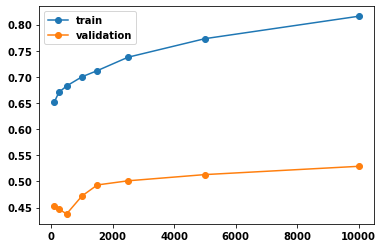

In [9]:
score=np.array(score)
plt.plot(n_estimators,score,'o-')
plt.legend(['train','validation'])
np.max(score[:,1])

In [10]:
n_estimator=n_estimators[np.argmax(score[:,1])]
model_XGB = XGBClassifier(n_estimators=n_estimator,
             learning_rate=learning_rate,
             early_stopping_rounds=10,
             )
    
model_XGB.fit(X_train,y_train,
         eval_set=[(X_valid, y_valid)],
         verbose=False)

pred_XGB=model_XGB.predict(X_valid)
pred_XGB=[np.argmax(x) for x in pred_XGB ]


## Deep Learning

This dataset is prone to lots of overfitting (bias) and also has a high ratio of numberof parameters to number of data points.

To get around the 2 issues:
- model has a high dropout rate 
- a relatively high number of units (i.e. a wide neural network)

For more information see the [kaggle notebook of keras binary EPL](https://www.kaggle.com/code/thomassimm/premier-league-predictions-using-tensorflow) which goes over this in more detail for the binary issue.


In [11]:
y_valid=pd.get_dummies(y_valid)
y_train=pd.get_dummies(y_train)

drop_pc=0.8
units=512*2
model=keras.Sequential([
        layers.Dense(units,activation='relu',input_shape=[np.shape(X_train)[1]]),
        layers.Dropout(drop_pc),
        layers.Dense(units,activation='relu'),
        layers.Dropout(drop_pc),
        layers.Dense(units,activation='relu'),
        layers.Dropout(drop_pc),
        layers.Dense(3,activation='softmax')
        ])

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    #loss='binary_crossentropy',#for binary classification 0-1
    metrics=['accuracy'],
)

In [12]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=40, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_accuracy',
)

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=len(X_valid),
    epochs=700,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 1.0254
Best Validation Accuracy: 0.5369


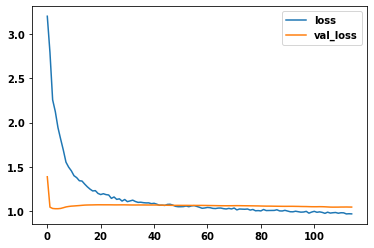

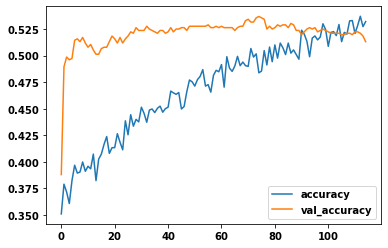

In [14]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [15]:
epochs=history_df['val_accuracy'].argmax()
model=keras.Sequential([
        layers.Dense(units,activation='relu',input_shape=[np.shape(X_train)[1]]),
        layers.Dropout(drop_pc),
        layers.Dense(units,activation='relu'),
        layers.Dropout(drop_pc),
        layers.Dense(units,activation='relu'),
        layers.Dropout(drop_pc),
        layers.Dense(3,activation='softmax')
        ])

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    #loss='binary_crossentropy',#for binary classification 0-1
    metrics=['accuracy'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=len(X_valid),
    epochs=epochs,
    verbose=0, # hide the output because we have so many epochs
)

In [16]:
preds=model.predict(X_valid).argmax(axis=1)
y_valid_=[np.argmax(y_valid.iloc[i,:]) for i in range(len(y_valid))]
acc_nn=accuracy_score(y_valid_,preds)

print(f"accuracy of nn model = {acc_nn:.3f}")

accuracy of nn model = 0.516


## Ensembling

Combine the results of the two models

In [17]:
preds_combo=(model.predict(X_valid)+ model_XGB.predict_proba(X_valid)).argmax(axis=1)

acc_combo=accuracy_score(y_valid_,preds_combo)

print(f"accuracy of combined model = {acc_combo:.3f}")

accuracy of combined model = 0.534
